# Libraries

In [53]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import scipy.stats 		 as stats
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [54]:
samplingFrequency = 400

ECG file headers

In [55]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [56]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [57]:
dataFolder = "../../../data/CODE15/hdf5/"

In [58]:
ecgFeatures = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [59]:
ecgTarget = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Dataset class

In [60]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score

In [61]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


In [62]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5"),
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [63]:
len(dataset)

20001

Dataloader

In [64]:
dataloader = DataLoader(
	dataset     = dataset,
	batch_size  = 1,
	shuffle     = False,
	num_workers = 4

)

# Model loading

In [65]:
class ECGReconstructor(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(12, 16, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(32, latentDim, 5, padding = 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(latentDim, 32, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(16, 12, 5, padding = 2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  

        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)

        return decoded

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ECGReconstructor(latentDim = 128).to(device)

model.load_state_dict(
    torch.load(
        "../../../models/t3/ae-t3-v0.pth", 
        weights_only = True
    )
)

model

ECGReconstructor(
  (encoder): Sequential(
    (0): Conv1d(12, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(32, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (decoder): Sequential(
    (0): Conv1d(128, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(16, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  )
)

# Graphical analysis of reconstruction performance

In [67]:
r2Scores = pd.DataFrame(
    columns = ecgTarget,
    index   = range(len(dataset))
)

correlations = pd.DataFrame(
    columns = ecgTarget,
    index   = range(len(dataset))
)

Calculating Pearson Correlations and r2 score for each ECG

In [68]:
model.eval()

with torch.no_grad():
	for i, (X, Y) in enumerate(dataloader):
		X, Y       =  X.to(device), Y.to(device)
		prediction =  model(X)

		prediction = prediction.cpu()[0]
		Y 		   = Y.cpu()[0]

		r2Row   	   = []
		correlationRow = []

		for j in range(len(ecgTarget)):

			yTrue = Y[:, j]
			yPred = prediction[:, j]

			r2 = r2_score(yTrue, yPred)

			if torch.std(yTrue) == 0 or torch.std(yPred) == 0:
				correlation = 0 
			else:
				correlation = stats.pearsonr(yTrue, yPred).statistic

			r2Row.append(r2)
			correlationRow.append(correlation)

		r2Scores.iloc[i]     = r2Row
		correlations.iloc[i] = correlationRow

The comparative plot function

In [69]:
def methodComparativePlot(df, derivation, method):
	dfMean = np.mean(df[derivation])
	dfMean = np.round(dfMean, 3)

	figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

	axes[0].set_title(f"{method}($ {derivation} $, $ {derivation}_{{rec}} $)")
	axes[1].set_title(f"Histograma - {method}($ {derivation} $, $ {derivation}_{{rec}} $)")

	axes[0].set_xlabel("n")
	axes[0].set_ylabel(f"{method}")
	
	axes[1].set_xlabel(f"{method}")
	axes[1].set_ylabel("Frequência")


	axes[0].scatter(
		df.index, 
		df[derivation]
	)
	axes[0].axhline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)


	counts, bins = np.histogram(df[derivation], 50)
	axes[1].stairs(counts / len(df[derivation]), bins, fill = True)
	axes[1].axvline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)

	axes[1].legend()
	axes[0].legend()

	plt.show()

	plt.close()

## Results

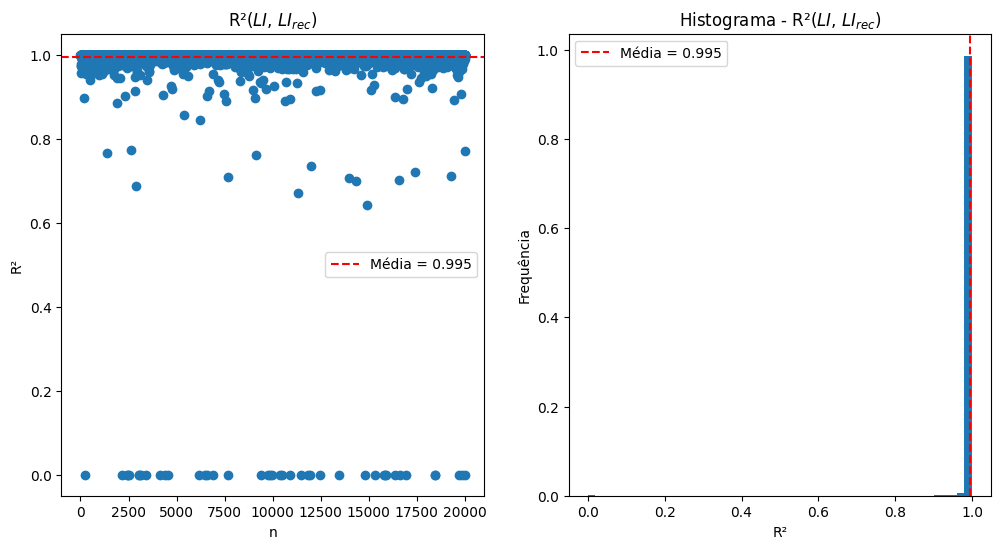

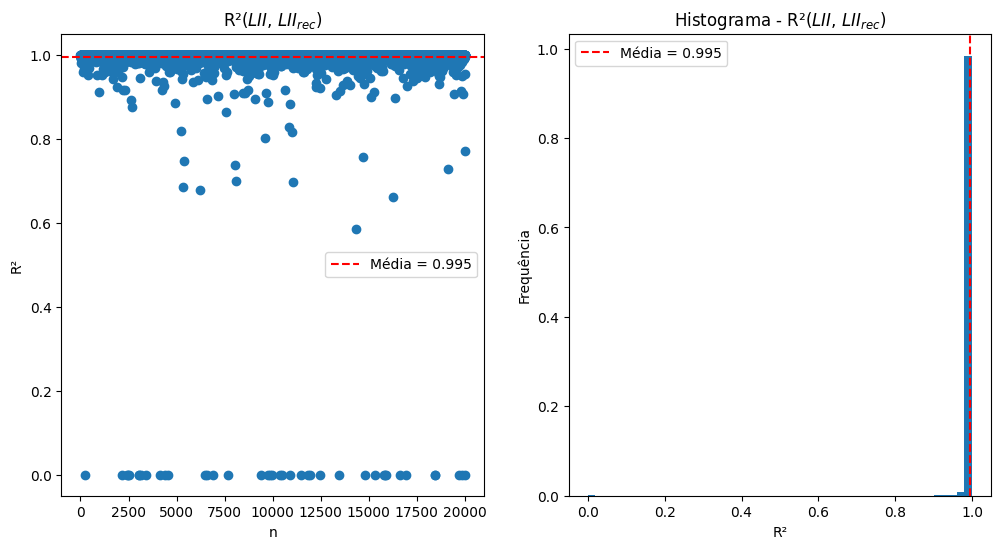

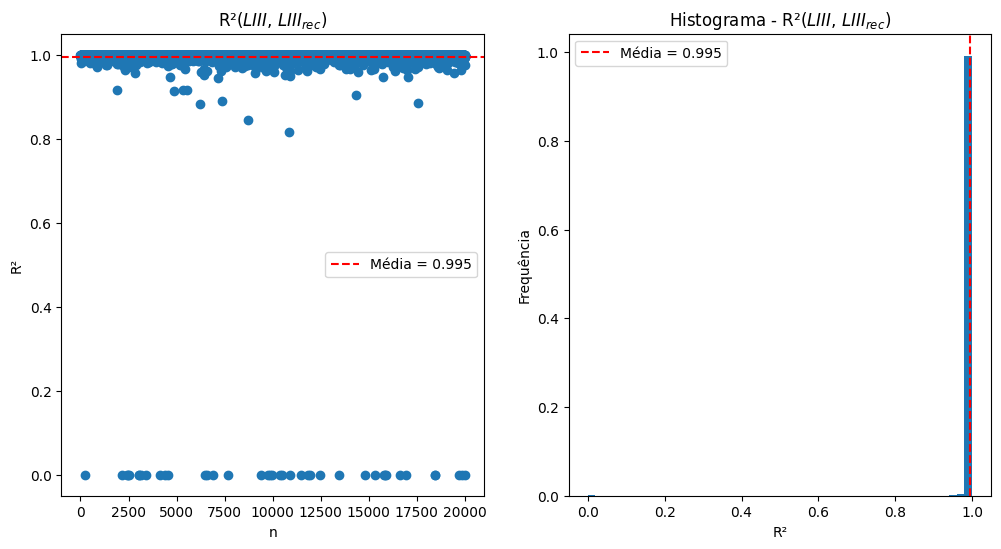

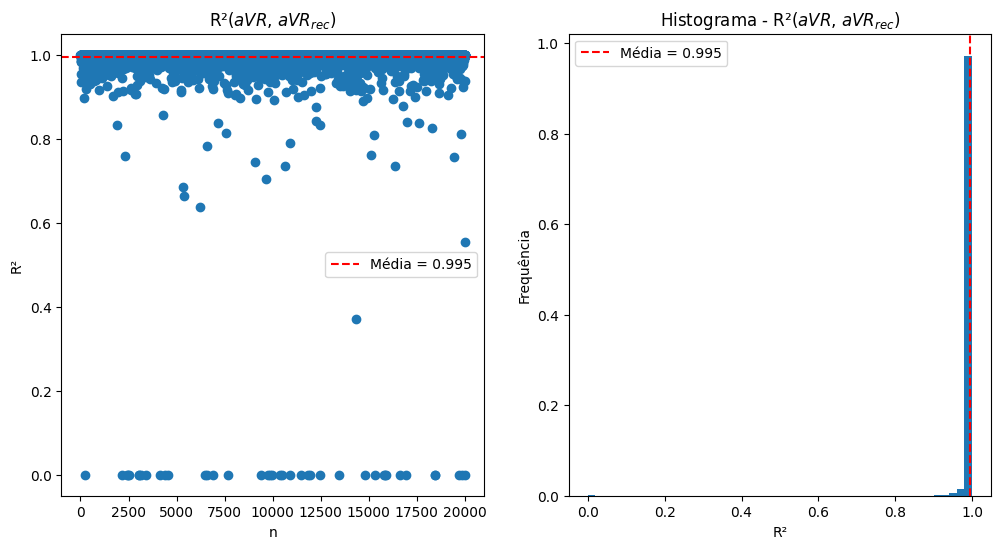

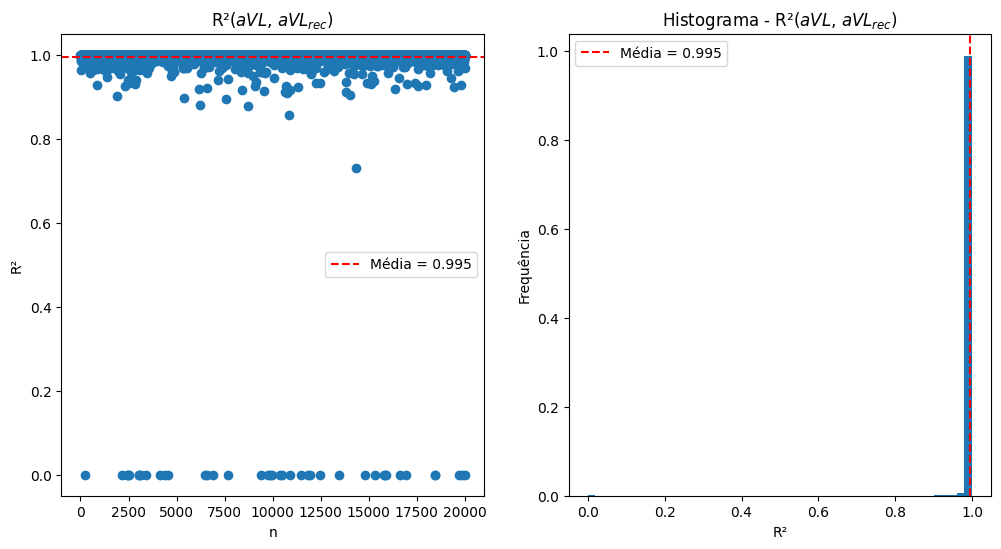

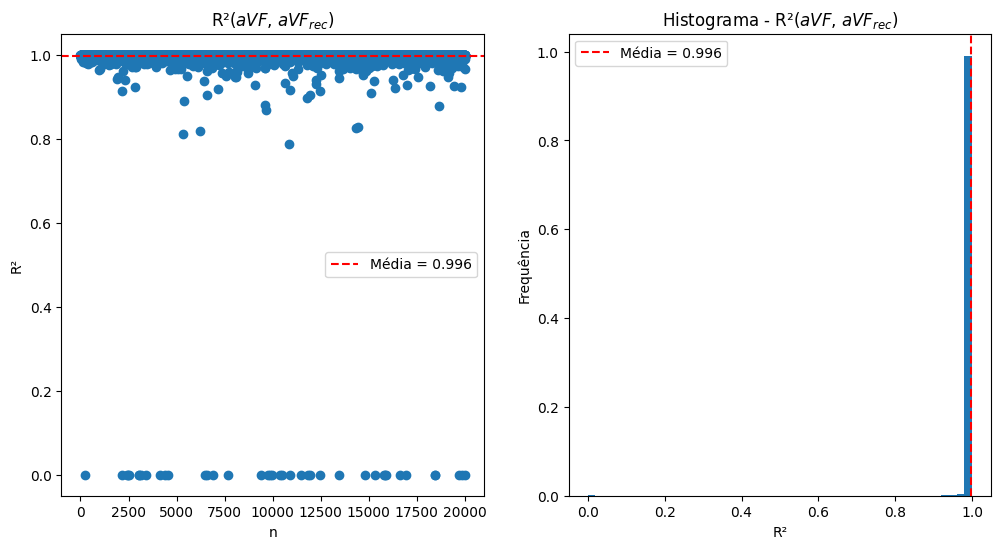

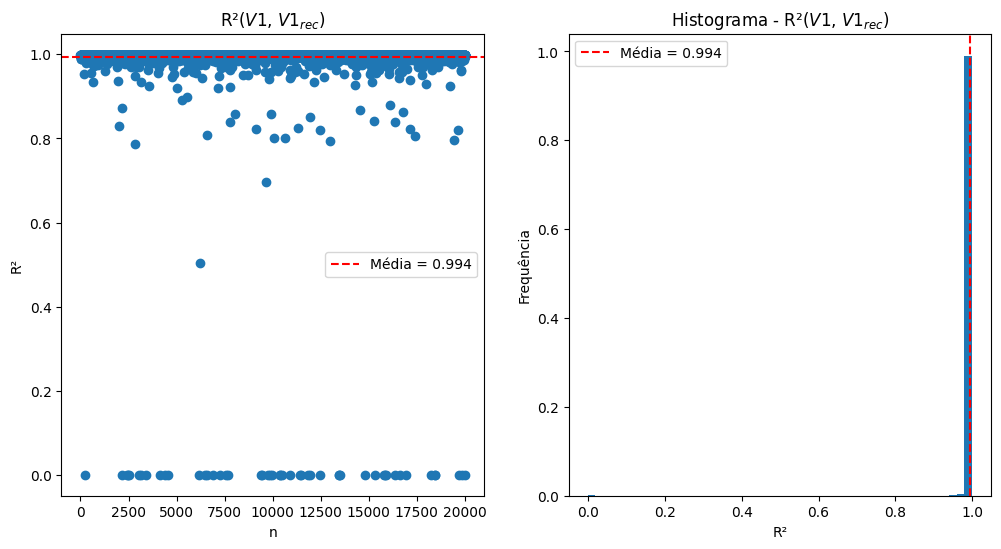

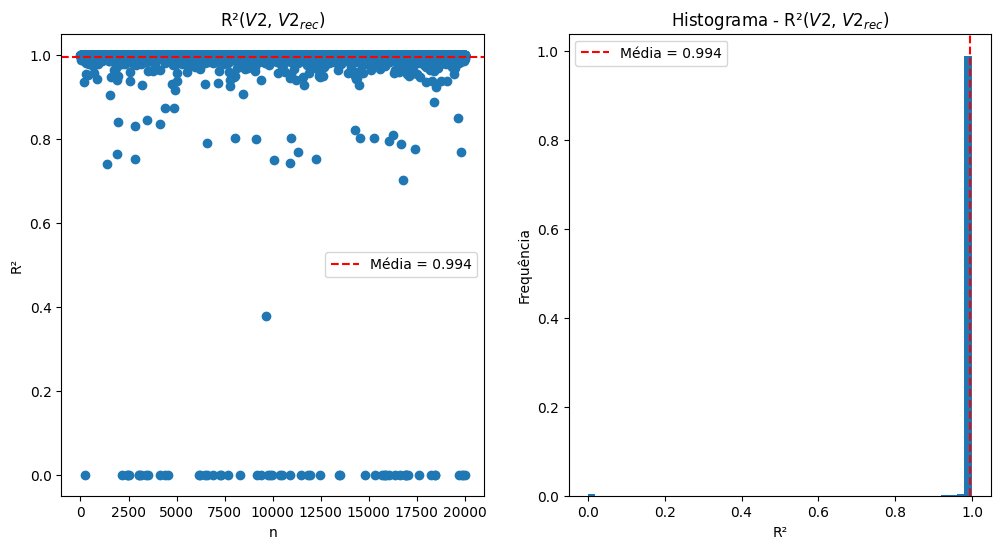

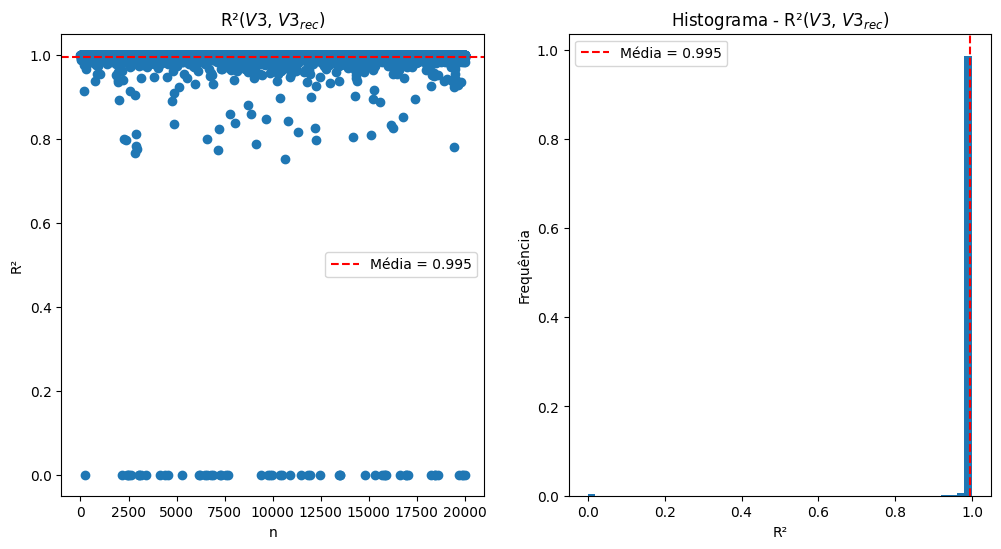

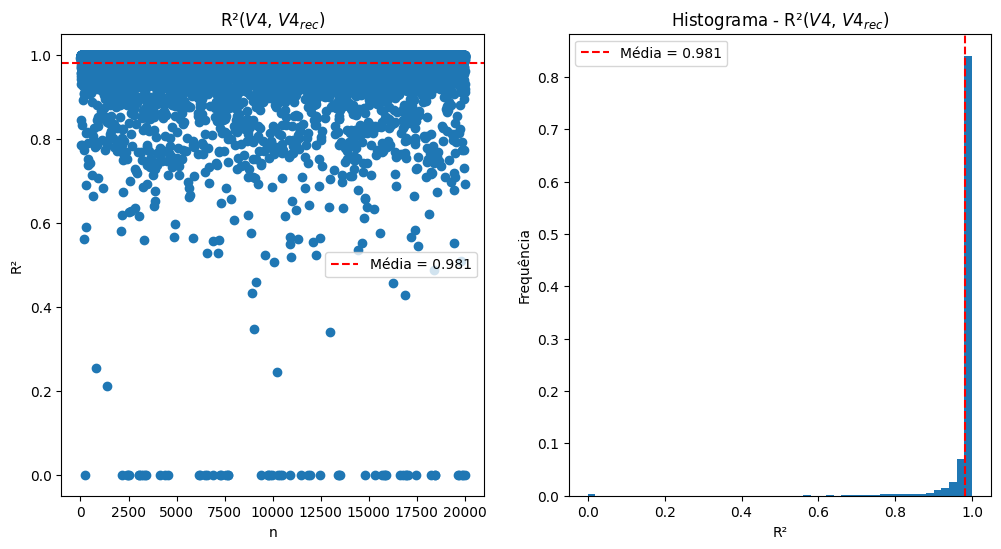

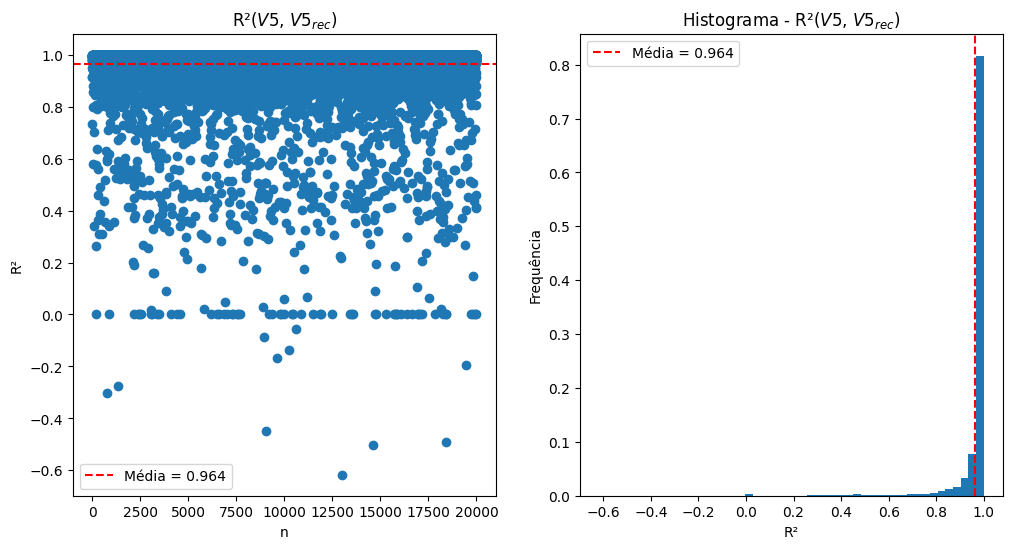

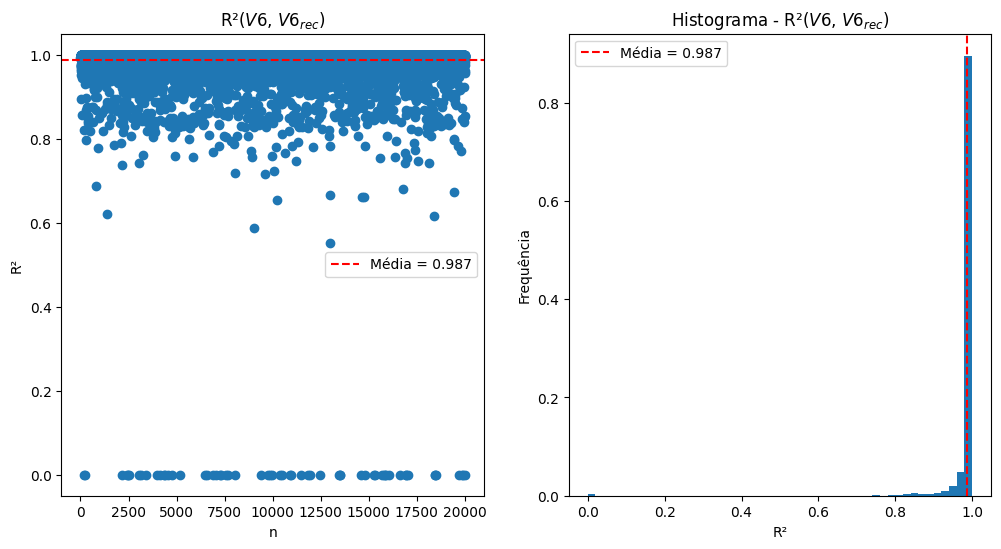

In [70]:
for derivation in ecgTarget:
	methodComparativePlot(r2Scores, derivation, "R²")

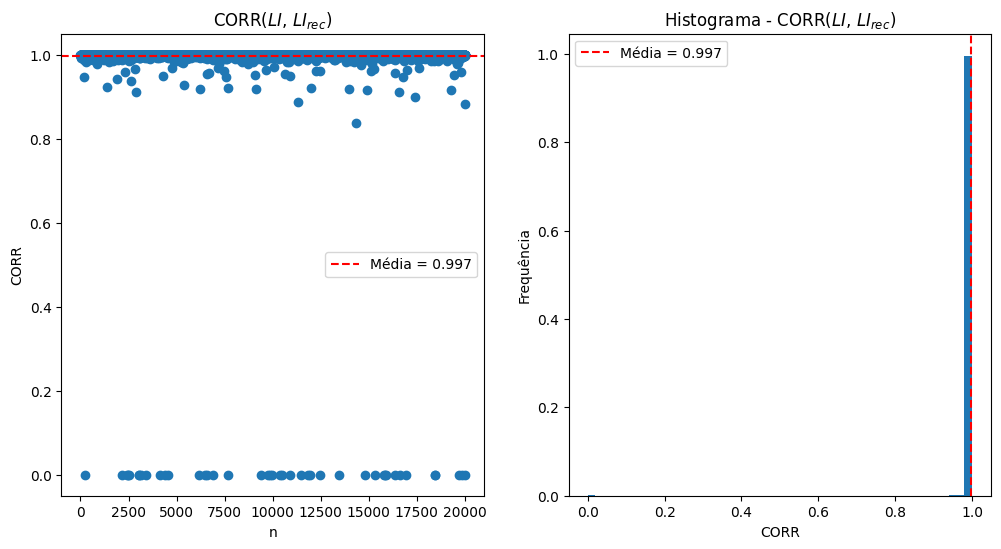

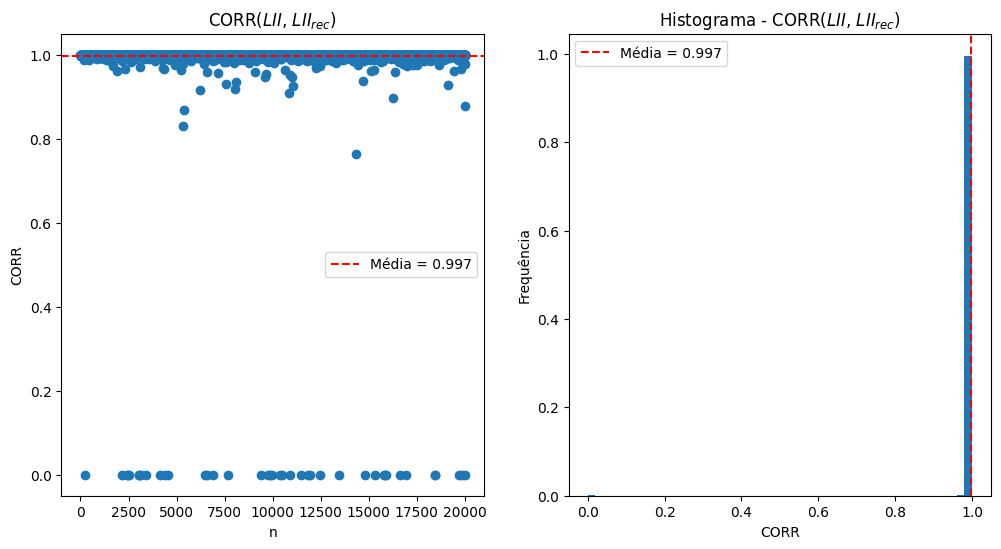

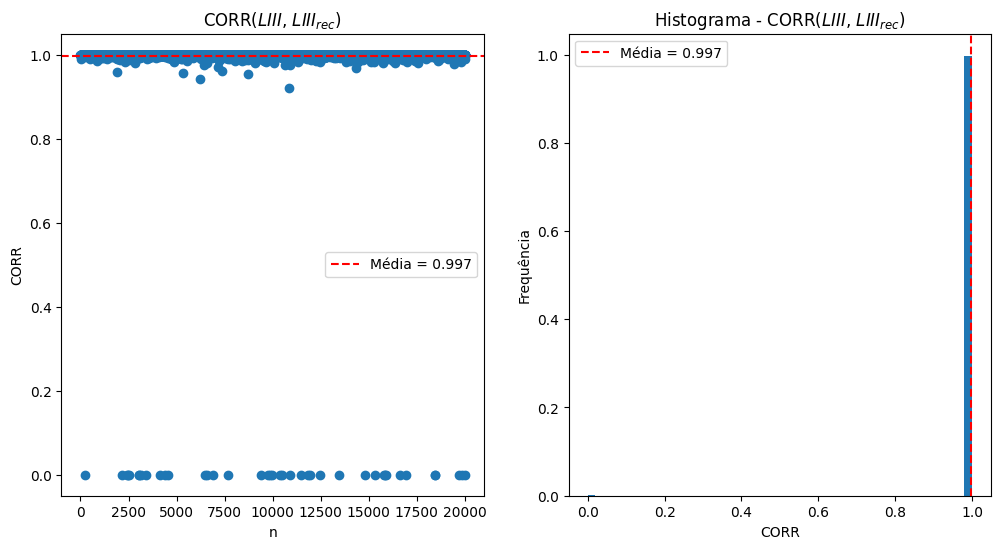

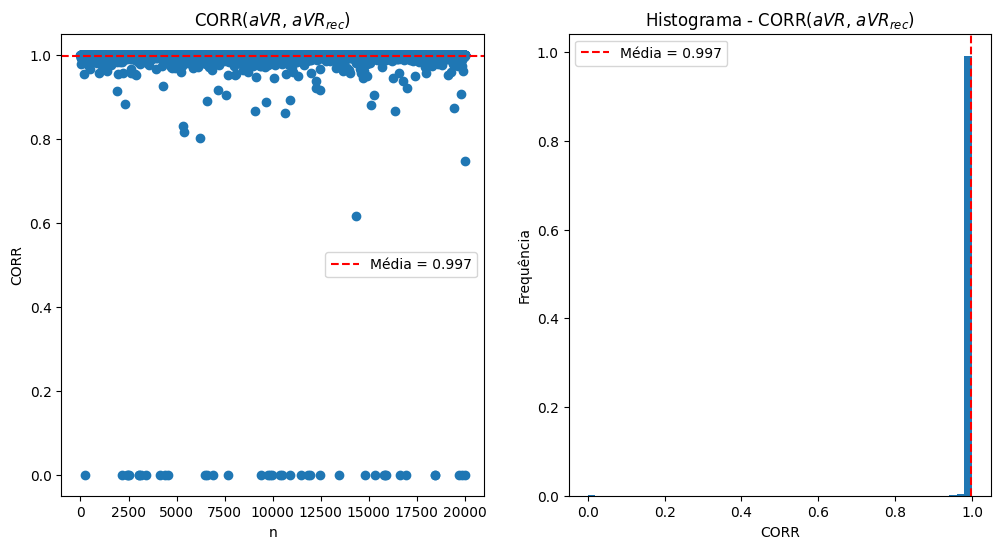

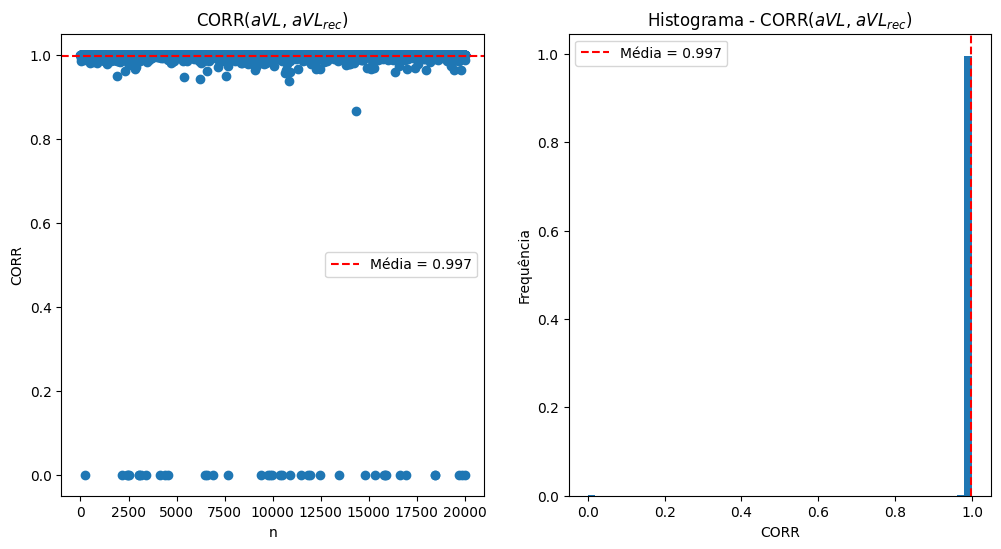

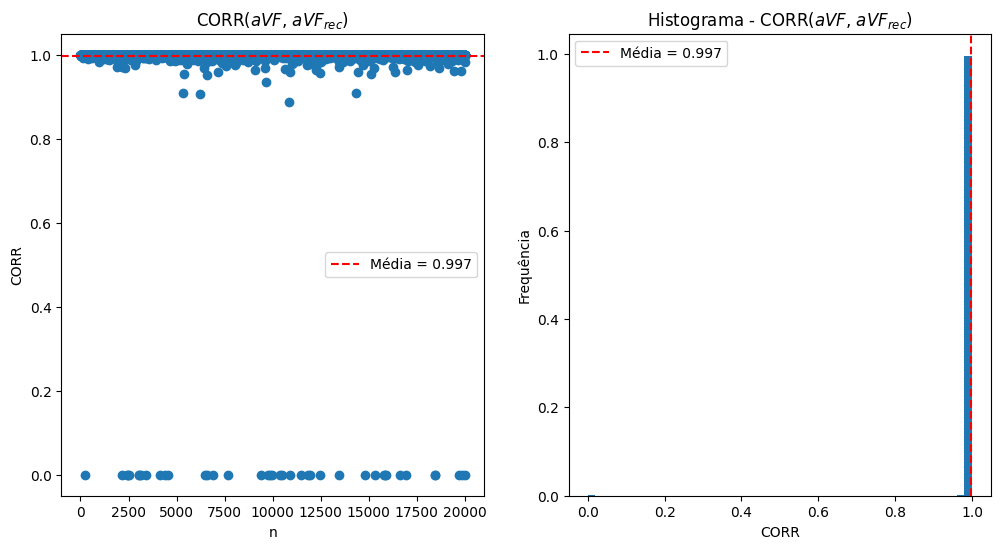

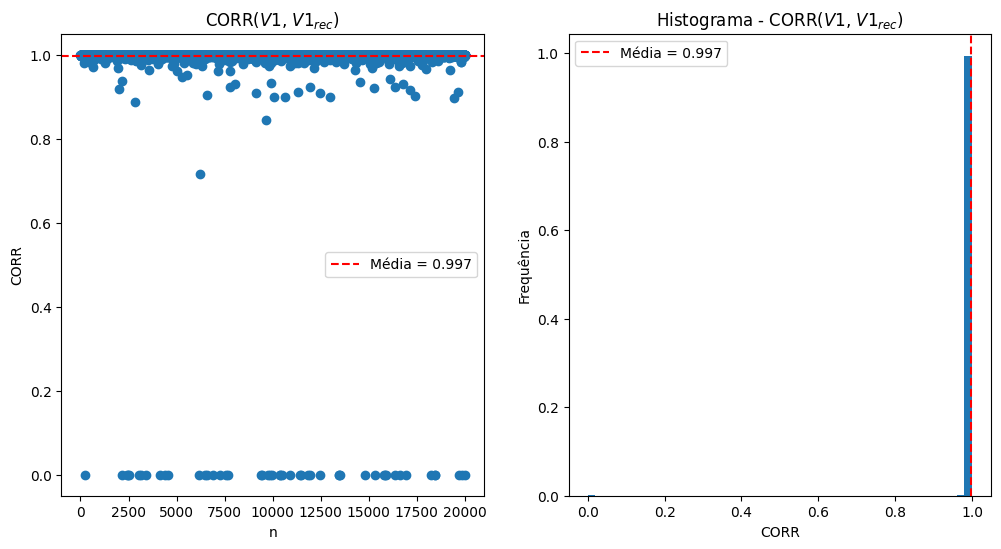

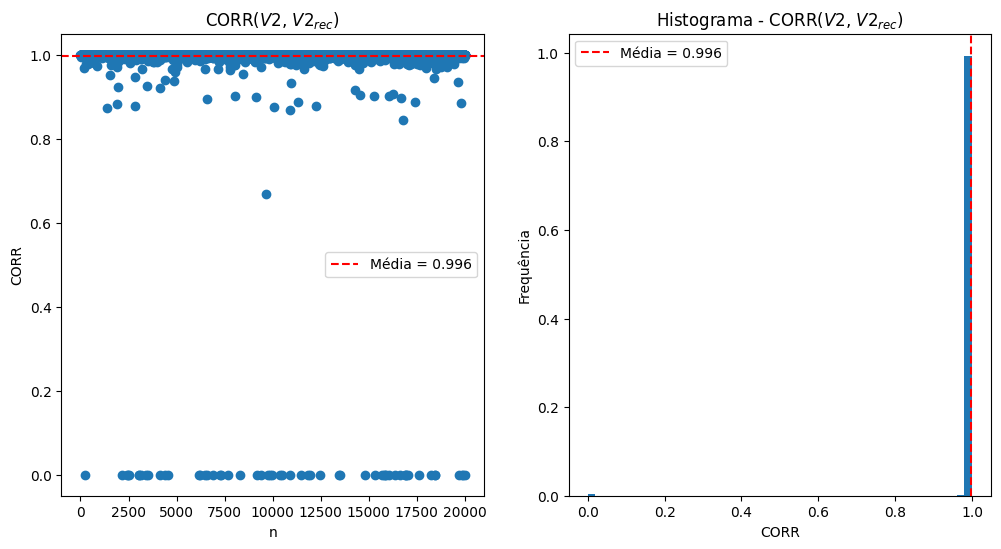

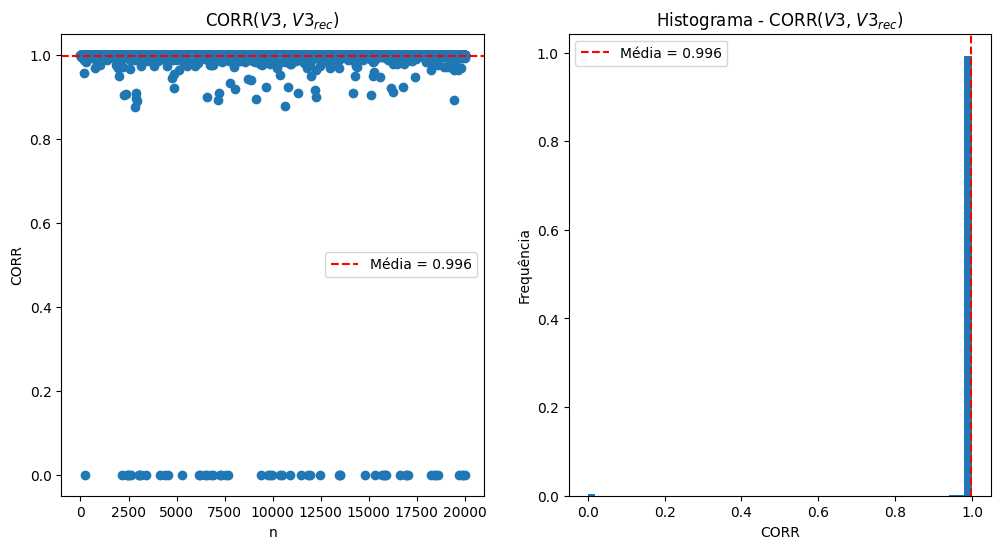

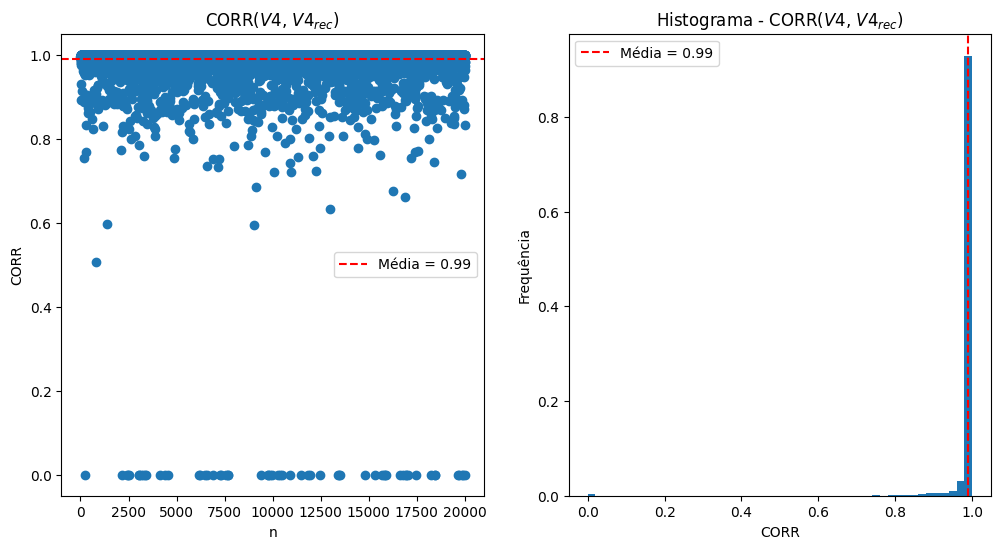

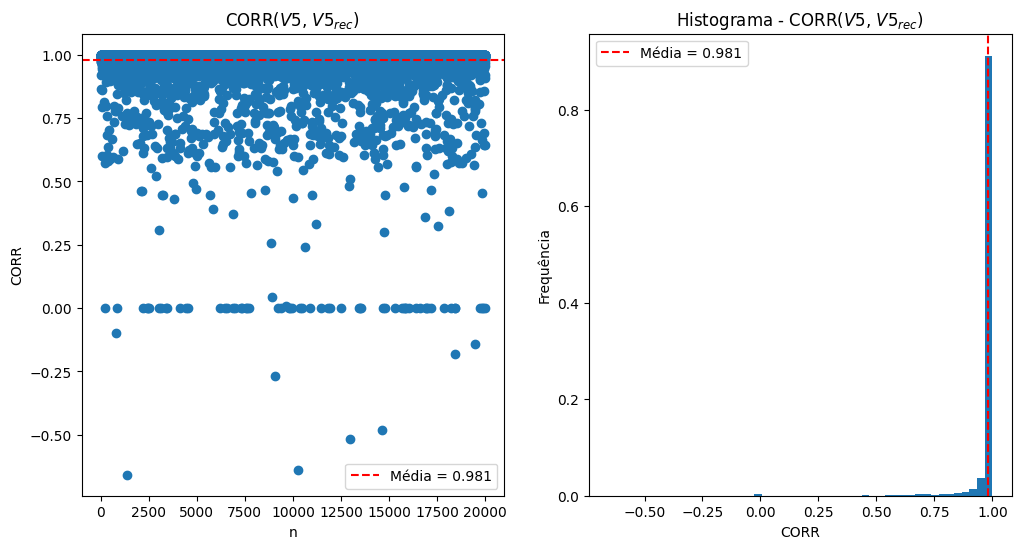

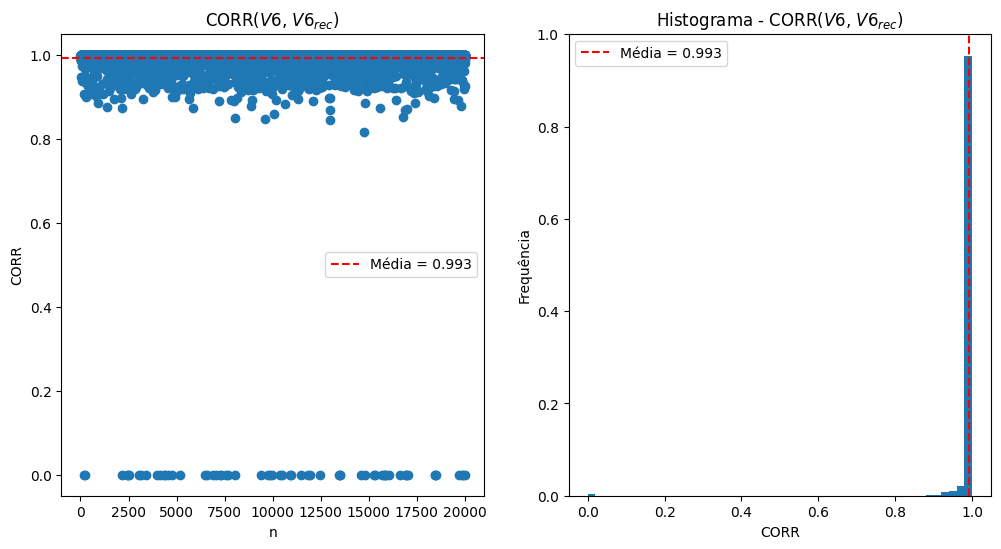

In [71]:
for derivation in ecgTarget:
	methodComparativePlot(correlations, derivation, "CORR")